In [86]:
import numpy as np
import pandas as pd
import csv
import random
import seaborn as sns

# Import packages for pre-processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


# Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

# Data Modelling
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YAS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [37]:
def load_train(path='sgarciba Sentence-Pair-Classification/snli_1.0/'):
    # Load the SNLI dataset
    train_data = pd.read_csv(path + 'snli_1.0_train.txt', sep="\t")
    train_data = pd.DataFrame(train_data, columns=['sentence1', 'sentence2', 'gold_label'])

    # Remove all the rows labeled as '-' and NaN values
    train_data = train_data.loc[train_data['gold_label'] != '-']
    train_data = train_data.dropna()

    # Create a subset of the data in order to run de model faster
    train_data = train_data.iloc[:10000,:]
    # Shuffle data
    train_data = train_data.sample(frac=1, random_state=203)
    return train_data



def load_test(path='sgarciba Sentence-Pair-Classification/snli_1.0/'):
    # Test set
    test_data = pd.read_csv(path + 'snli_1.0_test.txt', sep="\t")
    test_data = pd.DataFrame(test_data, columns=['sentence1', 'sentence2', 'gold_label'])

    # Remove all the rows labeled as '-' and NaN values
    test_data = test_data.loc[test_data['gold_label'] != '-']
    test_data = test_data.dropna()

    # Create a subset of the data in order to run de model faster
    test_data = test_data.iloc[:2500,:]
    return test_data

In [38]:
lemmat = WordNetLemmatizer()

def clean_sentence(sentence): 

    # Step 1: Transform text to lower case, remove url, some punctuations and long repeated characters 
    sent = sentence.lower()
    sent = re.sub(r'(http:)\S+', r'', sent)
    sent = re.sub(r'[\.,`=_/#]', r' ', sent)
    sent = re.sub(r'(\w)\1{2,}', r'\1\1', sent)

    # Step 2: Find the tokens of each text and apply lemmatization
    tokens = word_tokenize(sent)
    tokens = [lemmat.lemmatize(w) for w in tokens] 

    return ' '.join(tokens)

In [39]:
def vectorize_data(train_data, test_data):
    max_features = 300
    # Fit the vectorizer to the pair of training data and transform it separetely
    vectorizer = TfidfVectorizer(max_features = max_features, max_df = 0.5)
    # Join pair of sentences
    pair_train = [' '.join([s1,s2]) for s1,s2 in train_data[['clean_sent1', 'clean_sent2']].values]
    train_vec = vectorizer.fit(pair_train)

    # Transform sentence independently
    X_train1 = train_vec.transform(train_data['clean_sent1'].values)
    X_train2 = train_vec.transform(train_data['clean_sent2'].values)
    #Vectorize test sentences
    X_test1 = train_vec.transform(test_data['clean_sent1'].values)
    X_test2 = train_vec.transform(test_data['clean_sent2'].values)

    # print(X_train1.shape) (10000, 300)
    # print(X_train2.shape) (10000, 300)
    return X_train1, X_train2, X_test1, X_test2

In [40]:
# Create a Dictionary of labels with its cosine values
def dic_labels(x,y):
    
    dic = {
    'neutral': [],
    'entailment': [],
    'contradiction': []
    }
    
    for i,j in zip(x,y):
        if j == 'entailment':
            dic[j].append(i)
        elif j == 'neutral':
            dic[j].append(i)
        else:
            dic[j].append(i)
    
    return dic


def plot_similarity(train_data, X_train1, X_train2):
    # Compute distance metrics
    cosine = lambda x,y: cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]
    euclidean = lambda x,y: euclidean_distances(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]

    train_data['dist_cos'] = list(map(cosine, X_train1, X_train2))
    train_data['dist_euc'] = list(map(euclidean, X_train1, X_train2))

    dist_cos = dic_labels(train_data['dist_cos'].values, train_data['gold_label'].values)
    dist_euc = dic_labels(train_data['dist_euc'].values, train_data['gold_label'].values)

    # Cosine scores distribution by labels
    metric = ['Cosine', 'Euclidean']
    results = [dist_cos, dist_euc]
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    for i in range(0,2):
        sb.kdeplot(results[i]['neutral'], label='neutral', color='blue', ax=ax[i])
        sb.kdeplot(results[i]['entailment'], label='entailment', color='green', ax=ax[i])
        sb.kdeplot(results[i]['contradiction'], label='contradiction', color='red', ax=ax[i])
        ax[i].set_title(metric[i] + ' Distribution by labels')
        ax[i].legend()
    plt.show()

### Main

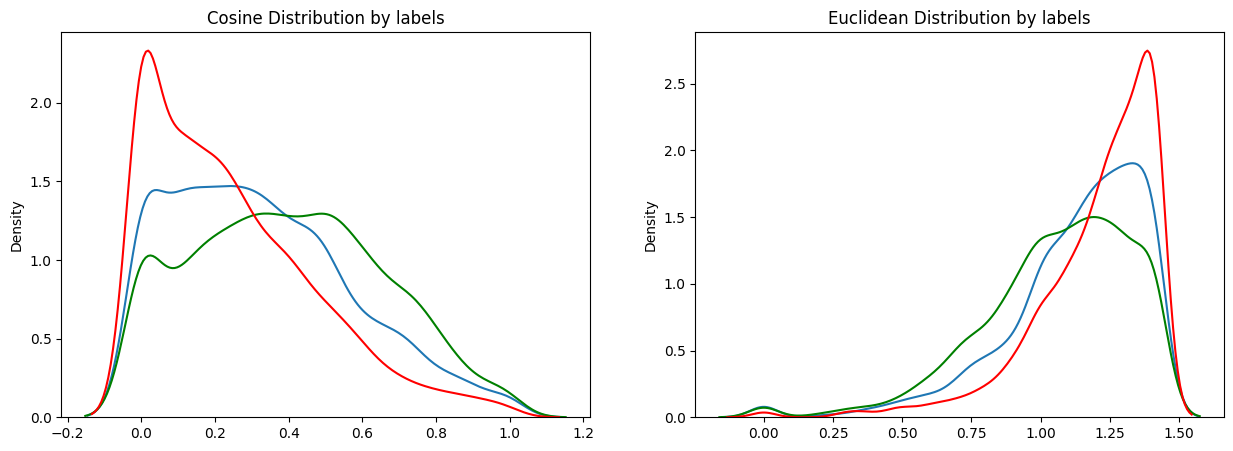

In [41]:
# main
train_data = load_train()
test_data = load_test()

# main
train_data['clean_sent1'] = train_data['sentence1'].map(lambda x: clean_sentence(x))
train_data['clean_sent2'] = train_data['sentence2'].map(lambda x: clean_sentence(x))

test_data['clean_sent1'] = test_data['sentence1'].map(lambda x: clean_sentence(x))
test_data['clean_sent2'] = test_data['sentence2'].map(lambda x: clean_sentence(x))

# main: Encode gold_label
dict_label = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
train_data['int_label'] = train_data['gold_label'].map(lambda x: dict_label[x])
test_data['int_label'] = test_data['gold_label'].map(lambda x: dict_label[x])

# main: Vectorize
X_train1, X_train2, X_test1, X_test2 = vectorize_data(train_data, test_data)

# main: plot similarity
plot_similarity(train_data, X_train1, X_train2)

In [81]:
train_data.head()

,sentence1,sentence2,gold_label,clean_sent1,clean_sent2,int_label,dist_cos,dist_euc
4638,Two small children playing football in yellow ...,two small children are playing football for th...,neutral,two small child playing football in yellow and...,two small child are playing football for their...,1,0.464148,1.035231
3472,Two asian females go walking.,The females are moving their legs.,entailment,two asian female go walking,the female are moving their leg,0,0.387333,1.106948
8723,A girl walking near a guy holding onto a bike ...,Two kids are riding mopeds.,contradiction,a girl walking near a guy holding onto a bike ...,two kid are riding moped,2,0.000000,1.414214
341,A man squatting in the foreground of a photogr...,A male skateboarder performs tricks outdoors f...,neutral,a man squatting in the foreground of a photogr...,a male skateboarder performs trick outdoors fo...,1,0.176306,1.283506
703,A man carrying a load of fresh direct boxes on...,A young lad delivers groceries by bicycle in t...,contradiction,a man carrying a load of fresh direct box on c...,a young lad delivers grocery by bicycle in the...,2,0.206059,1.260112


In [82]:
test_data.head()

,sentence1,sentence2,gold_label,clean_sent1,clean_sent2,int_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,this church choir sings to the mass a they sin...,the church ha crack in the ceiling,1
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment,this church choir sings to the mass a they sin...,the church is filled with song,0
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,this church choir sings to the mass a they sin...,a choir singing at a baseball game,2
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,a woman with a green headscarf blue shirt and ...,the woman is young,1
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,a woman with a green headscarf blue shirt and ...,the woman is very happy,0


In [83]:
# Size of the datasets 
print('Train Data size:', train_data.shape)
print('Test Data size:', test_data.shape)

# Labels distributions
# print('==Labels train set:==\n{}'.format(train_data['gold_label'].value_counts()))
# print('\n==Labels test set:==\n{}'.format(test_data['gold_label'].value_counts()))

Train Data size: (10000, 8)
Test Data size: (2500, 6)


<Axes: xlabel='gold_label', ylabel='count'>

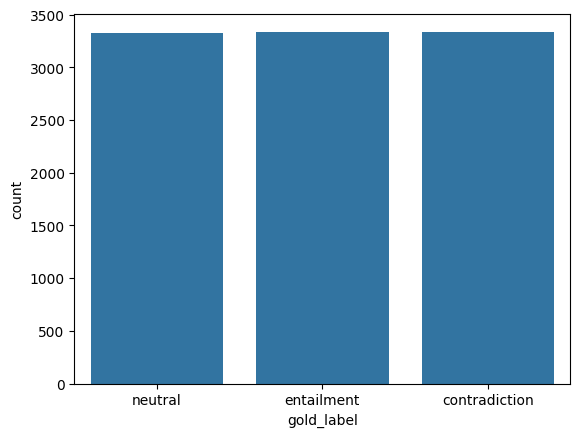

In [84]:
sns.countplot(train_data, x='gold_label')

<Axes: xlabel='gold_label', ylabel='count'>

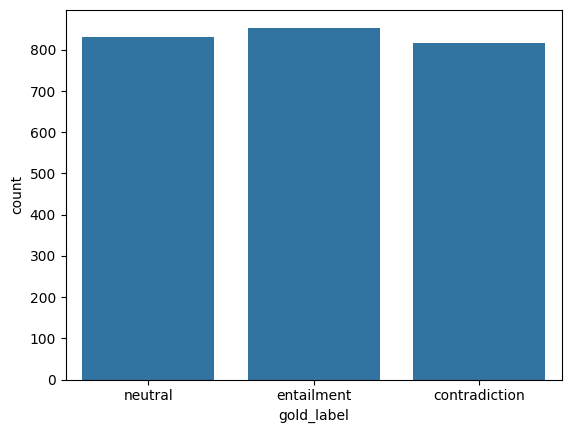

In [85]:
sns.countplot(test_data, x='gold_label')

### Running Model

In [42]:
# main: define X_train, X_test, y_train, and y_test

# Transform saprse matrix to numpy
# converts a matrix that only stores non-zero values and their positions into a matrix that includes all values, including zeros.
X_train1 = X_train1.todense().A
X_train2 = X_train2.todense().A
X_test1 = X_test1.todense().A
X_test2 = X_test2.todense().A

# The approach used to represent the input is going to be substraction (A sent_vector - B sent_vector)
# This subtraction results in a new vector that represents the semantic difference or relationship between the two sentences.
X_train = []
for i in range(0, X_train1.shape[0]):
    subs = X_train1[i] - X_train2[i]
    X_train.append(subs)
print('X_train Length:', len(X_train))
    
X_test = []
for i in range(0, X_test1.shape[0]):
    subs = X_test1[i] - X_test2[i]
    X_test.append(subs)

y_train = np.array(train_data['int_label'].values)
y_test = np.array(test_data['int_label'].values)
print('y_train Shape:', y_train.shape)

X_train Length: 10000
y_train Shape: (10000,)


In [45]:
# Models and corresponding parameter grids
models_params = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(n_jobs=-1),
        'params': {
            'solver' : ['newton-cg', 'saga', 'sag'],
            'C' : np.logspace(-10, 0, 10)
        }
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors' : [3, 5, 10],
            'weights': ["uniform", "distance"]
        },
    },
    {
        'name': 'SVC',
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['auto', 'scale']
        }
    },
    {
        'name': 'Random Forest Classifier',
        'model': RandomForestClassifier(n_jobs=-1),
        'params': {
            'n_estimators': [10,50,100],
            'criterion': ['gini', 'entropy']
        }
    }
]


In [51]:
# main: run model
t0 = time.time()
grid_searches = {} ## empty dictionary for the Grid.fit of each model
# Perform GridSearchCV for each model
for mp in models_params:
    model = mp['model']
    params = mp['params']
    model_name = mp['name']
    print('Running GridSearchCV for',model_name,'...')

    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    grid_searches[model_name] = grid_search
    
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    print()
print('Done.')

# Note: You can then evaluate the best models on your test set (X_test, y_test) using grid_search.best_estimator_
print('Time in minutes:', (time.time() - t0)/60)

Running GridSearchCV for Logistic Regression ...
Best parameters for LogisticRegression: {'C': 0.07742636826811278, 'solver': 'sag'}
Best cross-validation accuracy: 0.4945

Running GridSearchCV for KNN ...
Best parameters for KNeighborsClassifier: {'n_neighbors': 10, 'weights': 'uniform'}
Best cross-validation accuracy: 0.3953

Running GridSearchCV for SVC ...
Best parameters for SVC: {'C': 1, 'gamma': 'scale'}
Best cross-validation accuracy: 0.5339

Running GridSearchCV for Random Forest Classifier ...
Best parameters for RandomForestClassifier: {'criterion': 'entropy', 'n_estimators': 100}
Best cross-validation accuracy: 0.5004

Done.
Time in minutes: 23.542236336072285


In [79]:
frames = []
for name, grid_search in grid_searches.items():
    frame = pd.DataFrame(grid_search.cv_results_) # The results for every combination of param
    frame = frame.filter(regex='^(?!.*param_).*$') # remove columns about GRID parameters
    frame['estimator'] = len(frame)*[name] # add the name of the model for every combo 
    frames.append(frame)
df = pd.concat(frames) # final dict of all the training that the grid model has done
# df = df.drop(['rank_test_score', 'index'], axis=1)

# Reorder the columns so estimator is the first one
# columns = df.columns.tolist() 
# print(columns)
df = df.reindex(columns=['estimator', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 
 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
 'mean_test_score', 'std_test_score'])

results = df.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
cols = ['estimator', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
results = results[cols]
results.head(10)

,estimator,params,mean_test_score,mean_fit_time,mean_score_time
0,SVC,"{'C': 1, 'gamma': 'scale'}",0.5339,26.442570,7.140135
1,Random Forest Classifier,"{'criterion': 'entropy', 'n_estimators': 100}",0.5004,8.196307,0.072216
2,Random Forest Classifier,"{'criterion': 'entropy', 'n_estimators': 50}",0.4994,2.369662,0.047091
3,Random Forest Classifier,"{'criterion': 'gini', 'n_estimators': 100}",0.4993,3.819913,0.069094
4,SVC,"{'C': 10, 'gamma': 'auto'}",0.4985,28.326251,7.407364
5,SVC,"{'C': 0.1, 'gamma': 'scale'}",0.4973,27.116855,7.612170
6,Random Forest Classifier,"{'criterion': 'gini', 'n_estimators': 50}",0.4960,2.034603,0.047636
7,Logistic Regression,"{'C': 0.07742636826811278, 'solver': 'sag'}",0.4945,1.500397,0.007403
8,Logistic Regression,"{'C': 0.07742636826811278, 'solver': 'saga'}",0.4944,1.301827,0.006803
9,Logistic Regression,"{'C': 0.07742636826811278, 'solver': 'newton-cg'}",0.4944,1.031716,0.007204


<Axes: title={'center': 'mean_test_score'}, xlabel='estimator'>

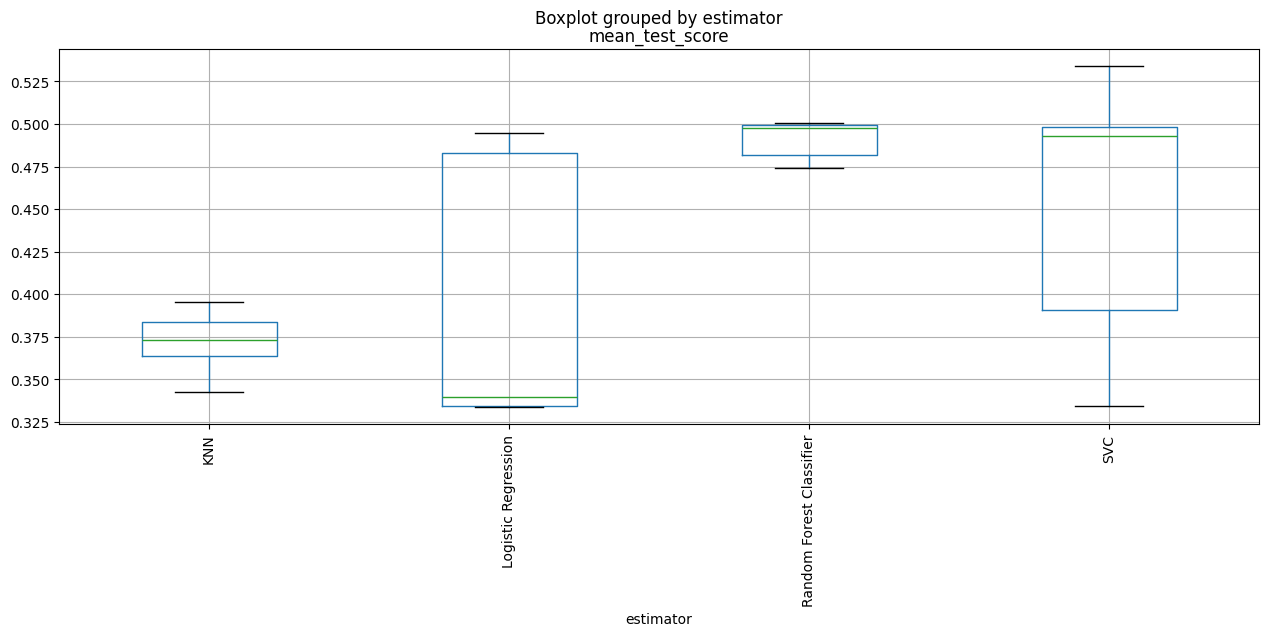

In [80]:
results.boxplot(column='mean_test_score',by='estimator', figsize=(15,5), rot=90)

### Testing

In [87]:
# Predictions for the test set
param = results.loc[0, 'params']
best_classifier = SVC(**param)
best_classifier.fit(X_train,y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.63       854
           1       0.57      0.48      0.52       830
           2       0.58      0.56      0.57       816

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.57      2500
weighted avg       0.58      0.58      0.57      2500



Confusion Matrix:
[[596 130 128]
 [241 395 194]
 [199 164 453]]


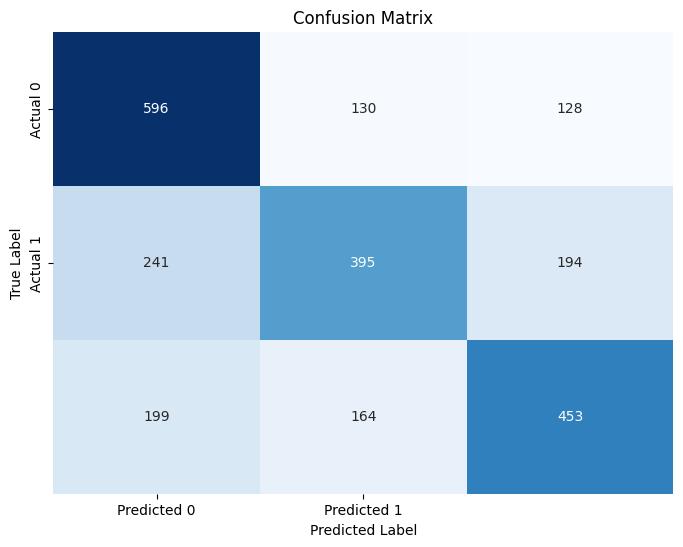

In [88]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Output the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [89]:
# Label the predictions with their correct name
labels_name = {0:'entailment', 1:'neutral', 2:'contradiction'}
label_pred = [labels_name[i] for i in y_pred] 

# Create a big data frame with the true labels and their predictions
final_df = test_data[['sentence1', 'sentence2', 'gold_label']]
final_df['predictions'] = label_pred 
final_df.head(10)

,sentence1,sentence2,gold_label,predictions
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,entailment
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment,contradiction
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,entailment
5,"A woman with a green headscarf, blue shirt and...",The woman has been shot.,contradiction,entailment
6,An old man with a package poses in front of an...,A man poses in front of an ad.,entailment,entailment
7,An old man with a package poses in front of an...,A man poses in front of an ad for beer.,neutral,neutral
8,An old man with a package poses in front of an...,A man walks by an ad.,contradiction,entailment
9,A statue at a museum that no seems to be looki...,The statue is offensive and people are mad tha...,neutral,entailment


### Draft

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import re
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Sample corpus of documents
# corpus = ['The quick brown fox jumps over the lazy dog.',
#           'The lazy dog likes to sleep all day.',
#           'The brown fox prefers to eat cheese.',
#           'The red fox jumps over the brown fox.',
#           'The brown dog chases the fox'
#          ]

# # Define a function to preprocess the text
# def preprocess_text(text):
#     # Remove punctuation and other non-alphanumeric characters
#     text =  re.sub('[^a-zA-Z]', ' ', text)
#     # Tokenize the text into words
#     words = word_tokenize(text.lower())
#     # Remove stop words
#     words = [word for word in words if word not in stopwords.words('english')]
#     # Join the words back into a string
#     return ' '.join(words)

# # Preprocess the corpus
# corpus = [preprocess_text(doc) for doc in corpus]
# print('Corpus: \n{}'.format(corpus))

# # Create a TfidfVectorizer object and fit it to the preprocessed corpus
# vectorizer = TfidfVectorizer()
# vectorizer.fit(corpus)

# # Get list of feature names that correspond to the columns in the TF-IDF matrix
# print("Feature Names:\n", vectorizer.get_feature_names_out())

# # Transform the preprocessed corpus into a TF-IDF matrix
# tf_idf_matrix = vectorizer.transform(corpus)

# # Print the resulting matrix
# print("TF-IDF Matrix:\n",tf_idf_matrix.toarray())
